In [1]:
# Author: Ahmet Ege Yilmaz
# Year: 2022
# Testing utils

import math,heapq
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram

from utils.algorithms.phase_estimator import get_phase_estimation
from utils.algorithms.grover import GroverSolver,get_diffuser,QCS,mQCS
from utils.misc import execute_circ,simulator,matrix_to_gate,get_counts,float2binary
from utils.gates import GreaterThanGate,PhaseEstimatorGate,LessThanGate

# Phase Estimation

2.5034566458293663


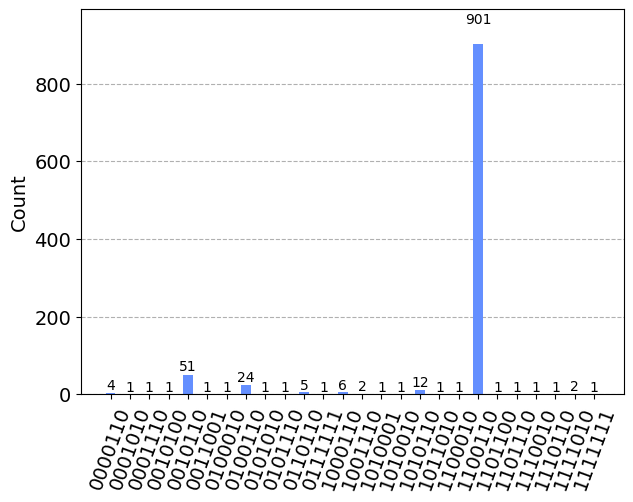

In [2]:

t = 7
theta = 0.4 # 0 < theta < 1
# theta = 0

theta = 2*np.pi * theta
unitary = QuantumCircuit(1)
unitary.p(theta,unitary.qubits)

circ = QuantumCircuit(1)
circ.x(0)

sol = get_phase_estimation(circ,unitary,t)

counts = sol['counts']

print(sol['phase'])
plot_histogram(counts)

# Grover

## Ex. 1: Pregiven good states

0.990234375


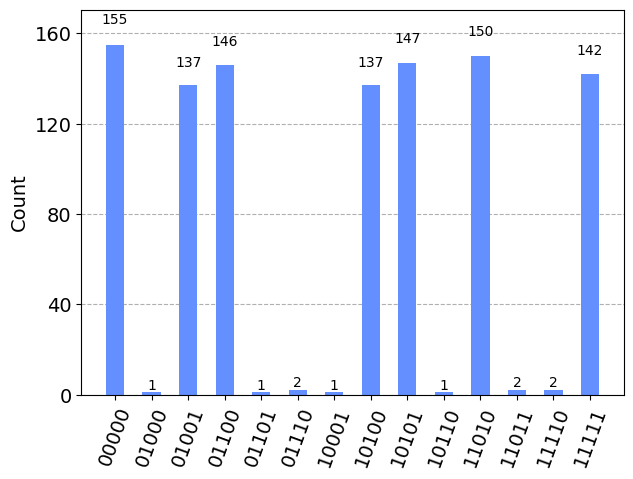

In [3]:
items = [12,[1,0,0,1],'11010','10101','0','11111','10100']
# items = [*range(5)]+[7]
# items = [0,1]
# items=[]

sol = GroverSolver(items)
circ, states = sol['circuit'], sol['states']
circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)
print(sum([counts[''.join(map(str,state))] for state in states])/sum(counts.values()))#total proba of chosen items

plot_histogram(counts)

## Ex. 2: Conditional Slicing (single list)

### Ex. 2.1: with Grover Search

Solutions:  [0.3] with indices: [2] O(sqrt(N/M))= 2.0
(Quantum Solution): 2
Note that the bits are shown in reverse order on the histogram.


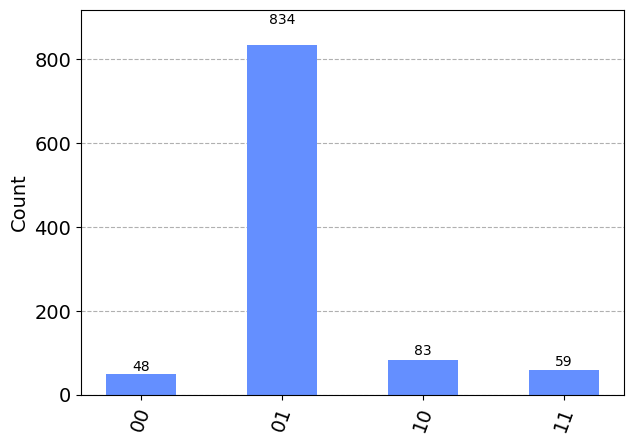

In [4]:
d = 0.1
threshold = .2
values = np.array([.0,.1,.3,.2])
##############

n_iqb = int(math.log2(len(values)))
assert n_iqb == math.log2(len(values))
N = 2**n_iqb
t = math.ceil(-math.log2(d)) # for greater-than / phase estimation
n = n_iqb + 2*t + 1 

assert np.any(values>threshold)
solutions = np.where(values>threshold)[0].tolist()
no_of_solutions = len(solutions)
print('Solutions: ', values[solutions], 'with indices:', solutions,'O(sqrt(N/M))=',np.sqrt(N/no_of_solutions))

condition_gate = GreaterThanGate(t)
t_grover = round(0.5 * (np.pi/(2*np.arcsin(np.sqrt(no_of_solutions/N))) - 1))
circ = QCS(values=values,threshold=threshold,condition_gate=condition_gate,t_grover=t_grover)
counts = get_counts(circ,circ.qubits[:n_iqb])

print('(Quantum Solution):',int(max(counts, key=counts.get)[::-1],2))
print('Note that the bits are shown in reverse order on the histogram.')

plot_histogram(counts)

### Ex. 2.2: with Exponential Search

In [5]:
n_iqb = 3
d = 0.01
threshold = 0.42
values = np.random.randint(0,100,2**n_iqb)/100
##############

N = 2**n_iqb
t = math.ceil(-math.log2(d)) # for greater-than / phase estimation
n = n_iqb + 2*t + 1 

assert np.any(values>threshold)
solutions = np.where(values>threshold)[0].tolist()
no_of_solutions = len(solutions)
print('Solutions: ', values[solutions], 'with indices:', solutions,'O(sqrt(N/M))=',np.sqrt(N/no_of_solutions))

condition_gate = GreaterThanGate(t)
f_check = lambda x: values[x]>threshold
index_ = QCS(values=values,threshold=threshold,condition_gate=condition_gate,f_check=f_check)

print(f'Quantum Solution:{index_,values[index_]}')

Solutions:  [0.45 0.66 0.5  0.98] with indices: [0, 1, 2, 3] O(sqrt(N/M))= 1.4142135623730951
Quantum Solution:(1, 0.66)


## Ex. 3: Conditional Slicing (multiple lists)

### Ex. 3.1: with Grover Search

Solutions:  [5, 6, 7]
Note that the bits are shown in reverse order on the histogram.
Solutions (indices):  5 6 7


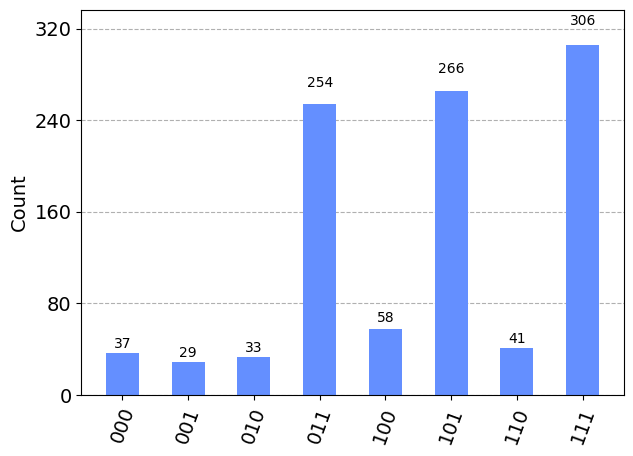

In [6]:
n_iqb = 3
N = 2**n_iqb

threshold1 = .4
threshold2 = .6
phases1 = np.array([0,1,3,2,4,5,6,5])/10
phases2 = np.array([3,2,1,0,6,5,1,2])/10
assert phases1.size == N and np.any(phases1>threshold1)
assert phases2.size == N and np.any(phases2<threshold2)
solutions = np.where((phases1>threshold1)*(phases2<threshold2))[0].tolist()
no_of_solutions = len(solutions)
assert no_of_solutions > 0
print('Solutions: ',solutions)

t_grover = round(0.5 * (np.pi/(2*np.arcsin(np.sqrt(no_of_solutions/N))) - 1))
d=0.1
t = math.ceil(-math.log2(d))

circ = mQCS([phases1,phases2],[threshold1,threshold2],[GreaterThanGate(t),LessThanGate(t)],t_grover=t_grover)
counts = get_counts(circ,[*range(n_iqb)])

print('Note that the bits are shown in reverse order on the histogram.')

solutions = heapq.nlargest(no_of_solutions,counts,counts.get)
print("Solutions (indices): ",*sorted([*map(lambda x: int(x[::-1],2),solutions)]))

plot_histogram(counts)

### Ex. 3.2: with Exponential Search

In [8]:
n_iqb = 3
d = 0.01
threshold1 = 0.42
threshold2 = 0.74
values1 = np.random.randint(0,100,2**n_iqb)/100
values2 = np.random.randint(0,100,2**n_iqb)/100
##############

t = math.ceil(-math.log2(d)) # for greater-than / phase estimation

assert np.any(values1>threshold1)
assert np.any(values2<threshold2)
solutions = np.where((values1>threshold1)*(values2<threshold2))[0].tolist()
no_of_solutions = len(solutions)
print('Solutions with indices:', solutions,'O(sqrt(N/M))=',np.sqrt(2**n_iqb/no_of_solutions))

f_check = lambda x: (values1[x]>threshold1)*(values2[x]<threshold2)
index_ = mQCS([values1,values2],[threshold1,threshold2],[GreaterThanGate(t),LessThanGate(t)],f_check=f_check)

print(f'Quantum Solution:{index_}')

Solutions with indices: [1, 2, 3, 5, 6] O(sqrt(N/M))= 1.2649110640673518
Quantum Solution:2


# Quantum Counting

In [ ]:
from matplotlib import pyplot as plt

m = 5 # m bits of accuracy
t = lambda eps: m + np.log2(2+1/(2*eps))

eps = np.linspace(0.1,1,10)
plt.plot(1-eps,t(eps)) #xaxis: success proba, yaxis: t (counting qubits)

In [ ]:
success_chance = 0.7
m = 4

# items = [*range(7)]
items = [12,[1,0,0,1],'1101','1010','0']
items = [0,1,2,3,5]
# items = []

sol = GroverSolver(items)
grover_op = sol['grover_op']

no_of_solutions, theta, err = get_count(m,success_chance,grover_op)

# It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative eigenvalue
theta = abs(np.pi-theta)
print('theta: ', theta/np.pi,'pi')

no_of_solutions = round(no_of_solutions)

no_of_solutions

## Refind Items

In [ ]:
n = 4
t = round(0.5 * (np.pi/theta - 1)) if theta != 0 else 0
circ = QuantumCircuit(n)
circ.h(circ.qubits)
for _ in range(t):
    circ.append(grover_op.to_gate(),circ.qubits)

circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)

plot_histogram(counts)